### Memprediksi Harga Rumah
Pada proyek ini tim kami akan menganalisis data harga rumah untuk kemudian membuat model untuk memprediksi harga rumah
Proyek ini terbagi menjadi beberapa bagian:
1. Eksplorasi Data
2. EDA
3. Data Preprocessing
4. Manipulasi Data
5. Seleksi Fitur
6. Model prediksi
<img src='rumah.jpg' width="1500" height="1000">

## 1. Explorasi Data
Mengecek missing values dan mengetahui karakteristik data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv('Housing.csv')
print(df.head(5))
print(df.shape)

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
(545, 13)


Data memiliki 13 fitur dan 545 sample

In [ ]:
#Cek missing values dan duplikasi
print(df.isna().sum())
print(f"Jumlah data duplikat : {df.duplicated().sum()}")

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
Jumlah data duplikat : 0


In [ ]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## 2. EDA
Melakukan analisis mendalam pada data untuk mengetahui pola dan hubungan.

In [ ]:
#Mengecek tipe fitur
target = 'price'
features = [i for i in df.columns if i not in [target]]
nu = df[features].nunique().sort_values()
nf = []; 
cf = []; 
original_df = df.copy(deep=True)

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:
        cf.append(nu.index[i])
    else: 
        nf.append(nu.index[i])
print(f"Dataset memiliki {len(nf)} fitur numerik dan {len(cf)} fitur kategorik ")

Dataset memiliki 1 fitur numerik dan 11 fitur kategorik 


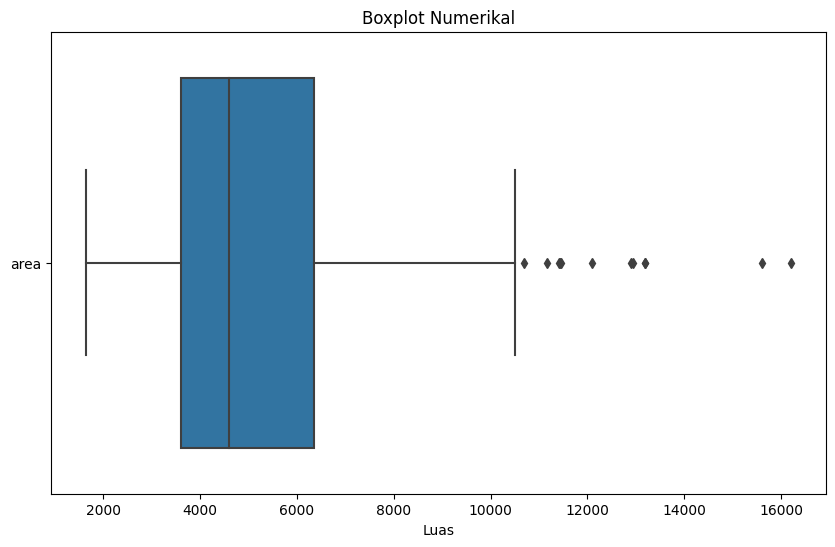

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[nf], orient="h")  # 'orient="h"' for horizontal boxplots
plt.title("Boxplot Numerikal")
plt.xlabel("Luas")
plt.show()

Terlihat beberapa outliers pada kolom area, nantinya akan diproses ketika fase data preprosessing

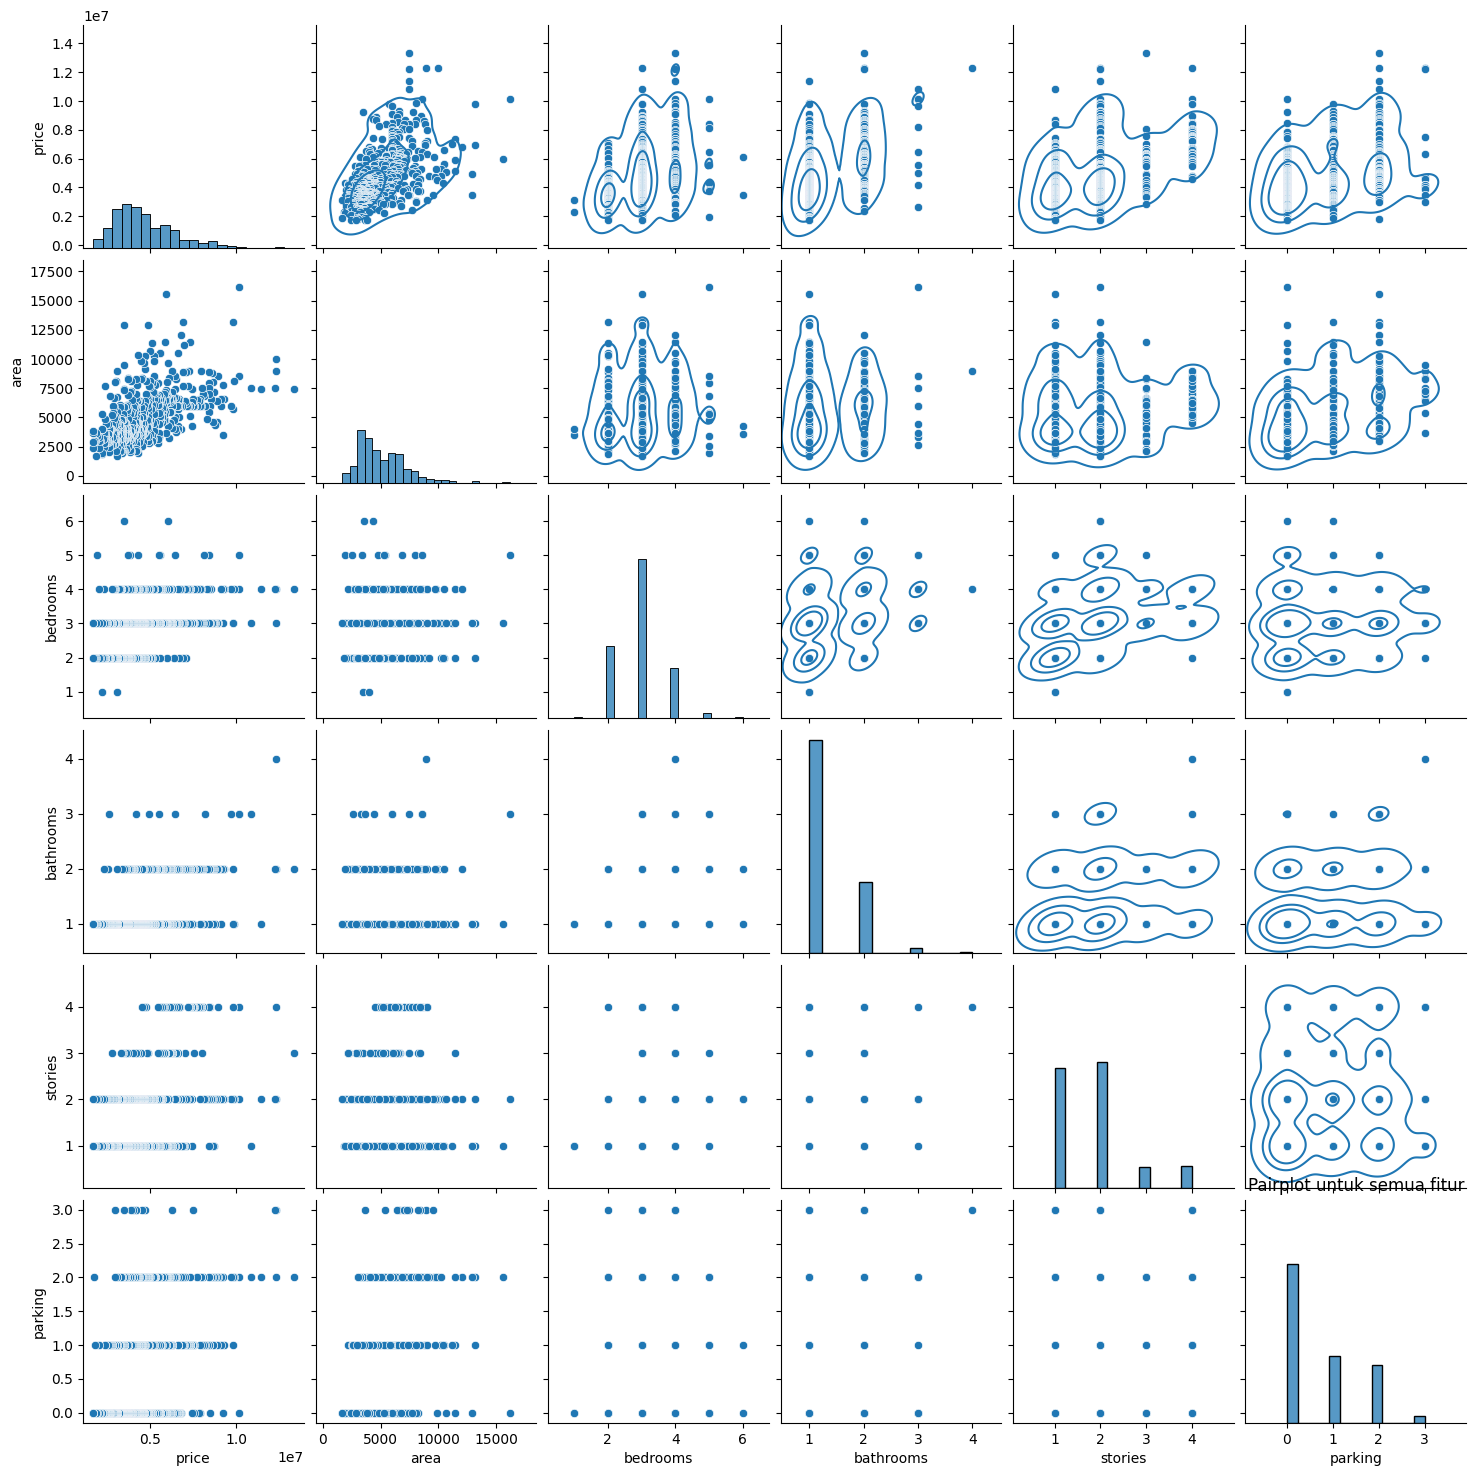

In [ ]:
#Mengecek hubungan tiap-tiap fitur
g = sns.pairplot(df)
plt.title('Pairplot untuk semua fitur')
g.map_upper(sns.kdeplot, levels=4)
plt.show()

## 

## 3. Data Preprocessing

tahapan untuk menghilangkan beberapa permasalahan yang bisa mengganggu saat pemrosesan data.

In [ ]:
#Penghapusan baris Duplikat apa pun (jika ada)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\nDataset tidak memiliki duplikat apapun')
else:
    print(f'\nJumlah duplikat dihilangkan/diperbaiki ---> {rs-df.shape[0]}')


Dataset tidak memiliki duplikat apapun


In [ ]:
#Periksa elemen kosong

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Persentase'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Persentase
price                             0         0.0
area                              0         0.0
bedrooms                          0         0.0
bathrooms                         0         0.0
stories                           0         0.0
mainroad                          0         0.0
guestroom                         0         0.0
basement                          0         0.0
hotwaterheating                   0         0.0
airconditioning                   0         0.0
parking                           0         0.0
prefarea                          0         0.0
furnishingstatus                  0         0.0


In [ ]:
#Mengubah Kolom Kategoris menjadi Numerik
df3 = df.copy()

ecc = nvc[nvc['Persentase']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("One-Hot Encoding pada fitur:")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\nDummy Encoding pada fitur:")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], 
        drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding pada fitur:
mainroad
guestroom
basement
hotwaterheating
airconditioning
prefarea

Dummy Encoding pada fitur:
furnishingstatus
bathrooms
stories
parking
bedrooms


(545, 24)

In [ ]:
#Penghapusan outlier:

df1 = df3.copy()
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('Sebelum penghapusan outlier, kumpulan data memiliki {} sampel.'.format(df3.shape[0]))
print('Setelah outlier dihilangkan, set data kini memiliki {} sampel.'.format(df1.shape[0]))
df.describe()

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,13300000,7420,1,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,12250000,8960,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,12250000,9960,1,0,1,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0
3,12215000,7500,1,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,11410000,7420,1,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


Sebelum penghapusan outlier, kumpulan data memiliki 545 sampel.
Setelah outlier dihilangkan, set data kini memiliki 533 sampel.


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


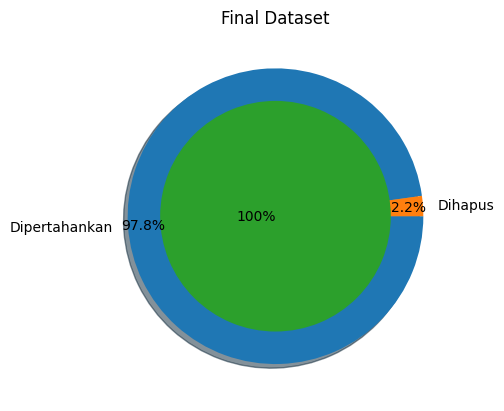

Setelah proses pembersihan(Cleanup), 12 samples di dropped, sambil mempertahankan 2.2% dari data.


In [ ]:
#Ukuran Dataset Akhir setelah melakukan Prapemrosesan

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Dipertahankan','Dihapus'],
        counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'Setelah proses pembersihan(Cleanup), {original_df.shape[0]-df.shape[0]} samples di dropped, \
sambil mempertahankan {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% dari data.')

## 4. Data Manipulation

In [ ]:
#Memisahkan data latihan & data uji

#library untuk membagi dataset jadi dua bagian 

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (533, 23) (533,) 
Training set  --->  (426, 23) (426,) 
Testing set   --->  (107, 23)  (107,)


In [ ]:
#Fitur Scaling (Standardisasi)

#library untuk melakukan berbagai jenis preprosesing data


std = StandardScaler()

print('\033[1mStandarisasi training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandarisasi test set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                             Standarisasi training set                                              


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,...,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02
mean,-6.463270e-17,9.799152e-17,-2.501911e-17,1.250956e-17,-3.544374e-17,1.355202e-17,-2.918896e-17,-1.876433e-17,-3.752867e-17,2.084926e-17,...,2.501911e-17,1.667941e-17,-1.459448e-17,-1.355202e-17,8.339703e-17,-8.756689e-17,2.501911e-17,1.667941e-17,8.339703e-17,-4.169852e-18
std,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,...,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00
min,-1.797874e+00,-2.335497e+00,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
25%,-7.487891e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
50%,-2.551019e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
75%,6.110159e-01,4.281744e-01,-4.659859e-01,1.322266e+00,-2.038745e-01,1.468181e+00,-5.393599e-01,1.186077e+00,1.429286e+00,1.150196e+00,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,1.674387e+00,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
max,2.992840e+00,4.281744e-01,2.145988e+00,1.322266e+00,4.904979e+00,1.468181e+00,1.854050e+00,1.186077e+00,1.429286e+00,1.726647e+00,...,3.699953e+00,3.633180e+00,1.829464e+00,2.032863e+00,6.806859e+00,1.674387e+00,9.275031e-01,2.180999e+00,6.806859e+00,2.061553e+01



                                                Standarisasi test set                                                


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,1.070000e+02,107.000000
mean,0.025531,0.144059,0.022233,-0.154083,0.130350,0.001839,0.042216,0.029248,0.016627,-0.040418,...,0.063671,0.126559,0.008549,-0.019996,0.048055,-0.130171,0.121488,0.010192,-1.469106e-01,0.144615
std,1.021135,0.843283,1.023054,0.947331,1.269193,1.005431,1.031339,1.009305,1.010644,0.980290,...,1.107146,1.192583,1.010164,0.988902,1.153328,0.922384,0.987957,1.013435,2.788619e-17,1.997668
min,-1.635477,-2.335497,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
25%,-0.809959,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
50%,-0.200970,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
75%,0.762586,0.428174,-0.465986,1.322266,-0.203874,1.468181,-0.539360,1.186077,1.429286,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
max,2.867794,0.428174,2.145988,1.322266,4.904979,1.468181,1.854050,1.186077,1.429286,1.726647,...,3.699953,3.633180,1.829464,2.032863,6.806859,1.674387,0.927503,2.180999,-1.469106e-01,20.615528


## 5. Seleksi Fitur

                                       Correlation Matrix                                       


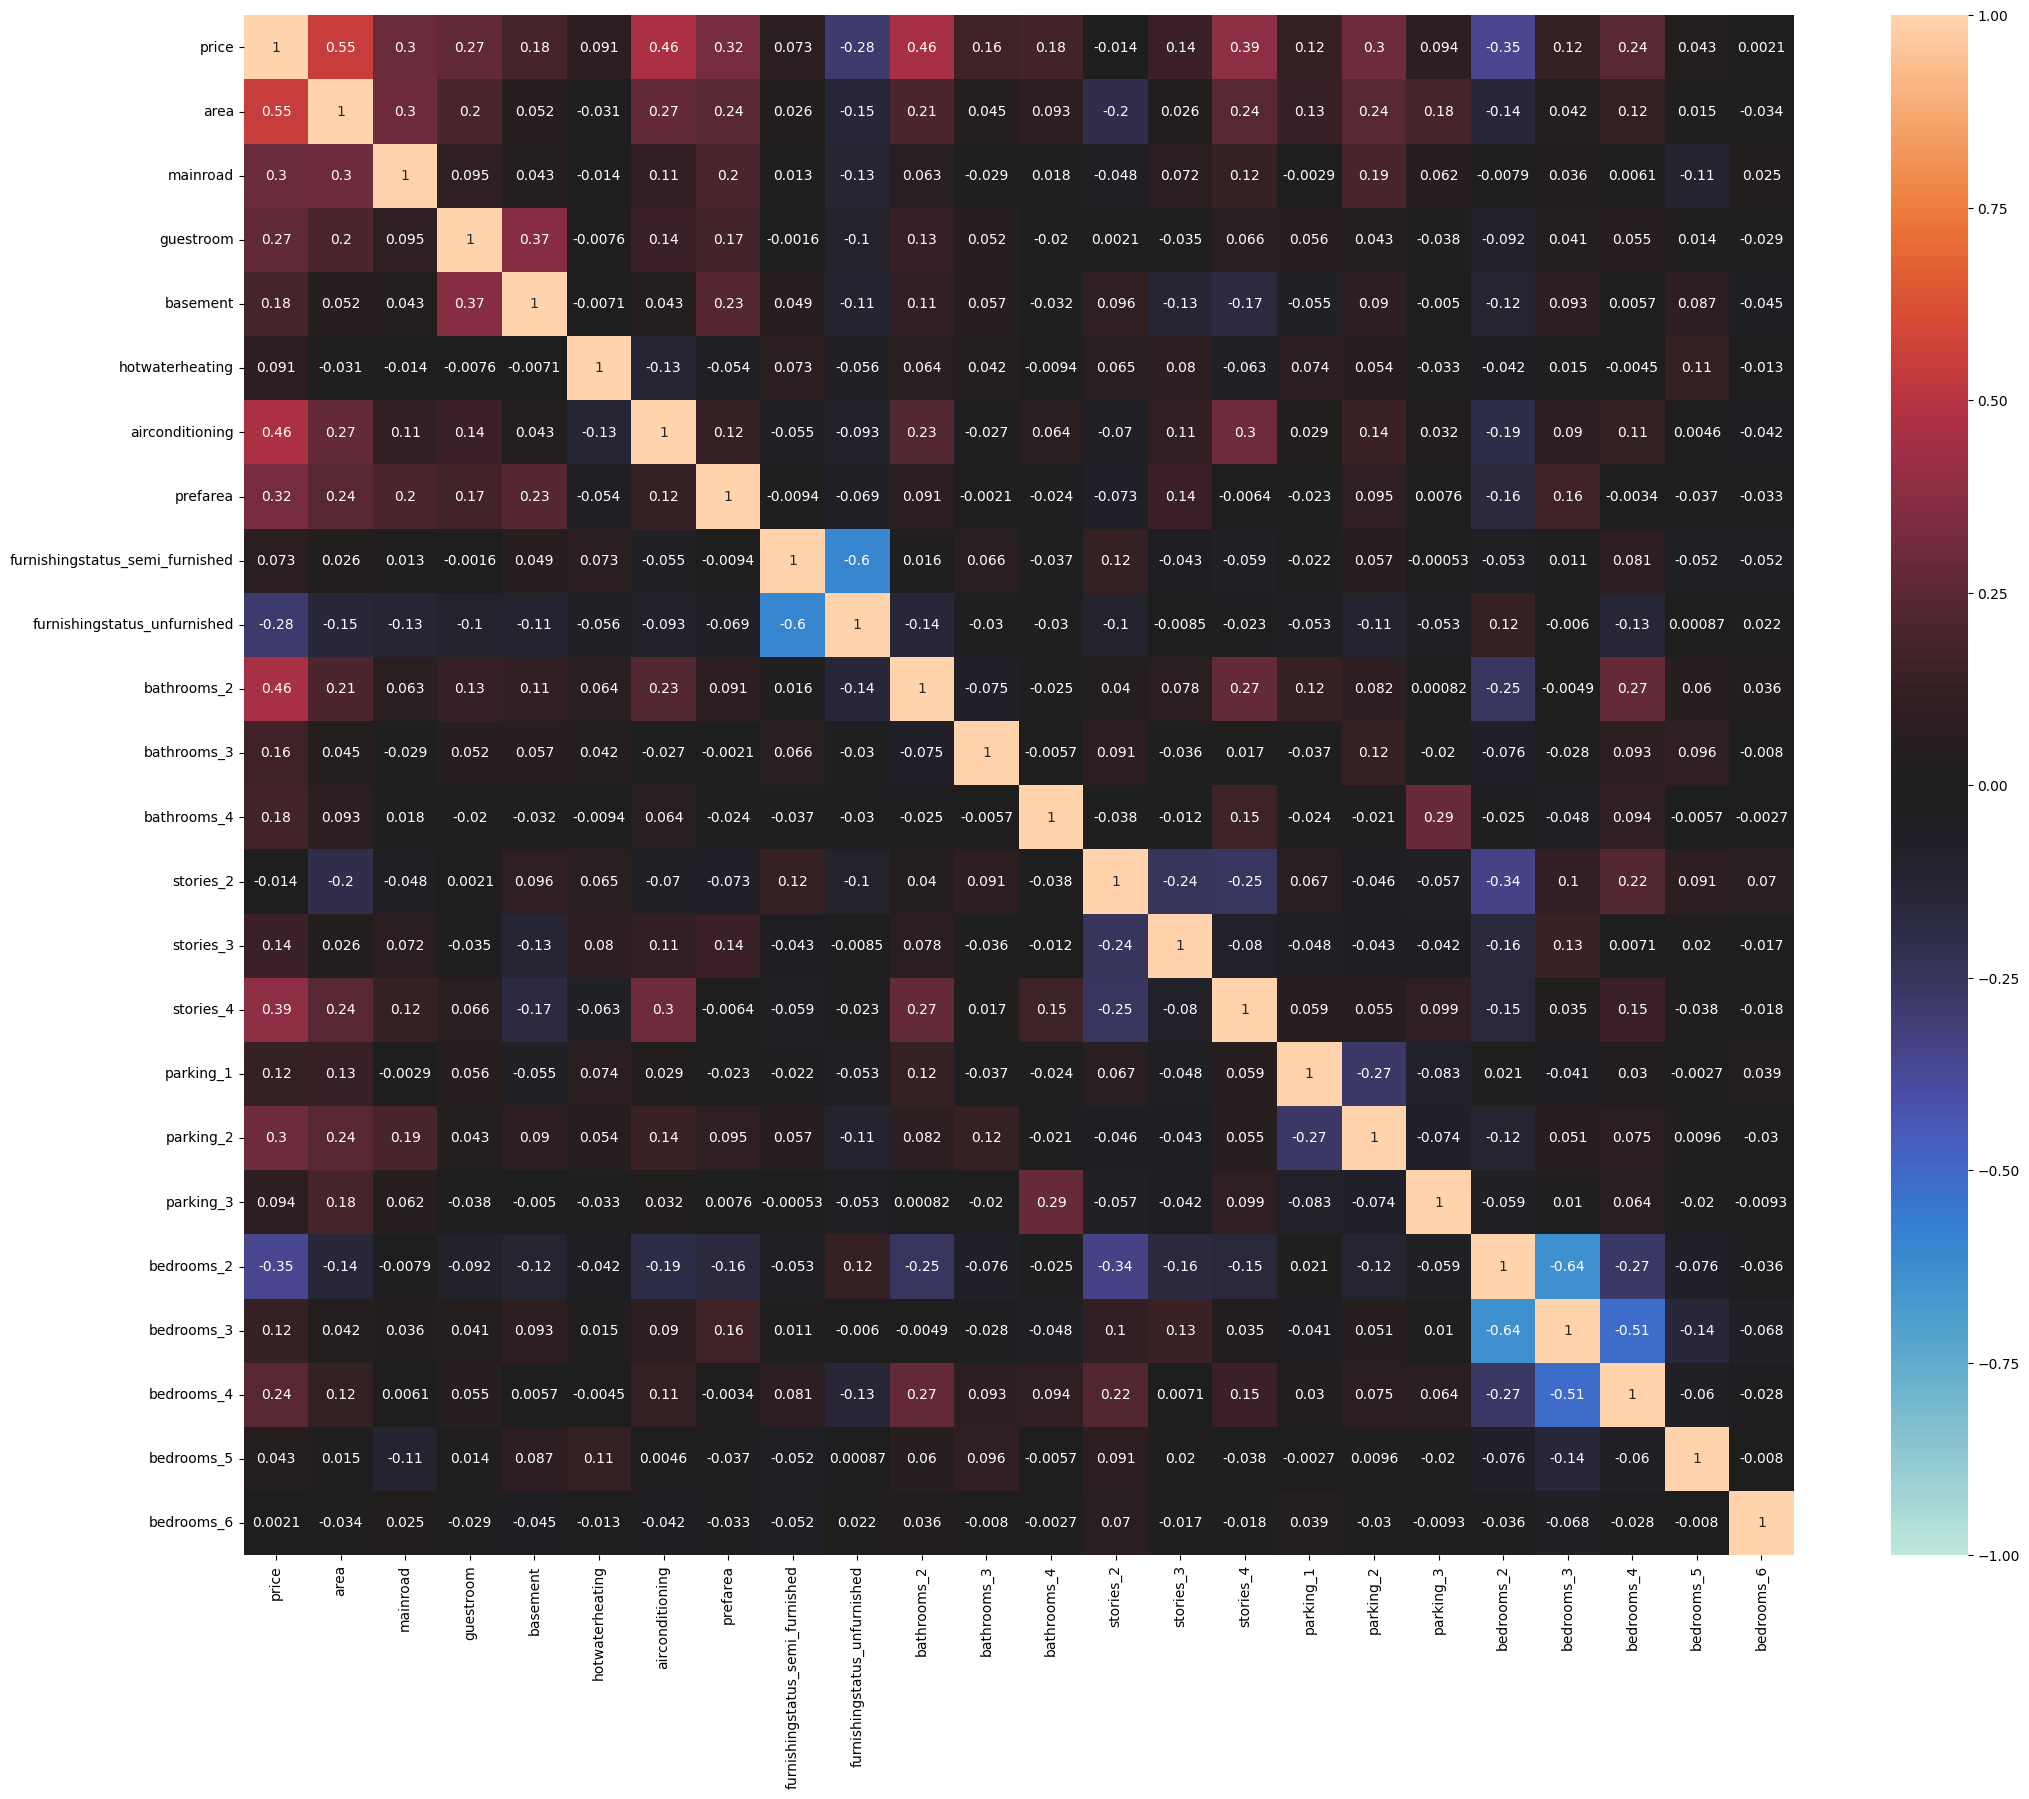

In [ ]:
#Memeriksa korelasi

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

### 5 Penghapusan Fitur - RFE

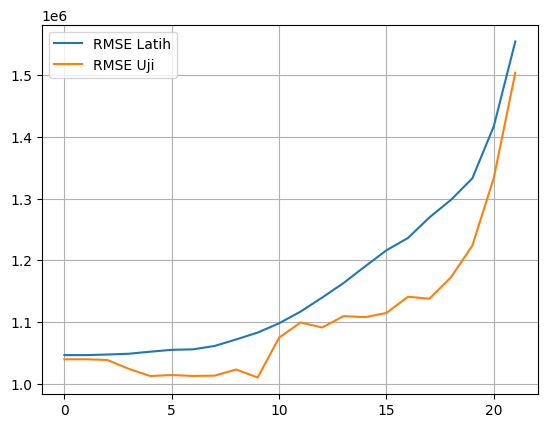

Tabel RMSE Latih:
              RMSE
0   1046443.289619
1   1046449.267268
2   1047388.183589
3   1048671.141565
4    1052002.15233
5   1055003.683786
6   1055844.976298
7   1061331.401939
8   1071881.710723
9   1082945.194607
10  1098118.482364
11  1117021.062137
12  1139616.357258
13  1163271.334248
14  1190187.747318
15  1216395.629435
16  1236326.433579
17   1269657.04956
18  1298022.114755
19  1333080.679471
20  1417572.391751
21  1554902.422516

Tabel RMSE Uji:
              RMSE
0   1039666.162213
1   1039731.709986
2   1038528.281004
3    1024192.83619
4   1012519.989372
5   1014158.320029
6   1012644.230379
7   1013191.654744
8    1023086.51544
9   1010188.880234
10  1074742.819935
11  1099360.592407
12  1091197.471855
13  1109650.390792
14  1107973.104311
15  1114812.113304
16  1141048.987561
17  1137856.107276
18  1172430.944782
19  1223982.219804
20  1334075.942154
21  1504322.621373


In [ ]:
# Jumlah fitur yang akan dihilangkan
jumlah_fitur_dihilangkan = 3

# Inisialisasi tempat penyimpanan
rmse_latih = []
rmse_uji = []

# Kolom data yang akan dihilangkan
kolom_dihilangkan = ['ord-' + str(i) for i in range(2, 2 + jumlah_fitur_dihilangkan)]

# Inisialisasi DataFrame untuk menyimpan RMSE
df_rmse_latih = pd.DataFrame(index=range(jumlah_fitur_dihilangkan), columns=['RMSE'])
df_rmse_uji = pd.DataFrame(index=range(jumlah_fitur_dihilangkan), columns=['RMSE'])

# Jumlah total fitur
jumlah_fitur = df.shape[1] - 2

for i in range(jumlah_fitur):
    # Buat model regresi linier dan RFE
    regresi_linier = LinearRegression()
    rfe = RFE(estimator=regresi_linier, n_features_to_select=jumlah_fitur - i)

    # Pasang RFE pada data training
    rfe.fit(Train_X_std, Train_Y)

    # Dapatkan fitur terpilih
    fitur_terpilih = Train_X_std.columns[rfe.support_]

    # Latih model regresi linier dengan fitur terpilih
    regresi_linier.fit(Train_X_std[fitur_terpilih], Train_Y)

    # Buat prediksi pada data training dan testing
    prediksi_latih = regresi_linier.predict(Train_X_std[fitur_terpilih])
    prediksi_uji = regresi_linier.predict(Test_X_std[fitur_terpilih])

    # Hitung dan simpan RMSE untuk data training dan testing
    rmse_latih.append(np.sqrt(mean_squared_error(Train_Y, prediksi_latih)))
    rmse_uji.append(np.sqrt(mean_squared_error(Test_Y, prediksi_uji)))

    # Simpan RMSE dalam DataFrame
    df_rmse_latih.loc[i, 'RMSE'] = rmse_latih[i]
    df_rmse_uji.loc[i, 'RMSE'] = rmse_uji[i]

# Plot hasil
plt.plot(df_rmse_latih['RMSE'], label='RMSE Latih')
plt.plot(df_rmse_uji['RMSE'], label='RMSE Uji')
#plt.ylim([19.75, 20.75])  # Tidak perlu jika ingin plot menyesuaikan otomatis
plt.legend()
plt.grid()
plt.show()

# Tampilkan tabel RMSE
print("Tabel RMSE Latih:")
print(df_rmse_latih)
print("\nTabel RMSE Uji:")
print(df_rmse_uji)


In [ ]:
#Memilih fitur-fitur yang penting dengan menggunakan teknik (RFE)

# Impor library yang dibutuhkan
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

# Jumlah fitur yang ingin dipilih
jumlah_fitur_dipilih = 5

# Buat objek regresi linier dan RFE
regresi_linier = LinearRegression()
rfe = RFE(estimator=regresi_linier, n_features_to_select=jumlah_fitur_dipilih)

# Jalankan RFE pada data training dan target
rfe.fit(Train_X_std, Train_Y)

# Dapatkan fitur terpilih
fitur_terpilih = Train_X_std.columns[rfe.support_]

# Latih model regresi linier menggunakan fitur terpilih
regresi_linier.fit(Train_X_std[fitur_terpilih], Train_Y)

# Buat prediksi pada data training dan testing
prediksi_latih = regresi_linier.predict(Train_X_std[fitur_terpilih])
prediksi_uji = regresi_linier.predict(Test_X_std[fitur_terpilih])

# Hitung dan tampilkan RMSE
rmse_latih = np.sqrt(mean_squared_error(Train_Y, prediksi_latih))
rmse_uji = np.sqrt(mean_squared_error(Test_Y, prediksi_uji))

print(f"RMSE Latih: {rmse_latih:.4f}")
print(f"RMSE Uji: {rmse_uji:.4f}")


RMSE Latih: 1269657.0496
RMSE Uji: 1137856.1073


Meskipun terlihat multi-colinearitas pada heatmap namun tidak masalah dan dapat lanjut ke bagian Machine Learning tanpa perlu feature engineering karena Algoritma Advance Machine Learning yang digunakan dapat mengatasi multi-colinearitas. Dan secara pemahaman, fitur-fitur yang ada pada data sangat masuk akal untuk diperhitungkan dalam memprediksi harga rumah.

## 6 Membuat Model

In [ ]:
#Membuat fungsi evaluasi untuk setiap model
def evaluasi_model(n, pred1, pred2):
    
    # Evaluasi model Multiple Linear Regression
    r2_train = r2_score(Train_Y, pred1)
    rss_train = np.sum(np.square(Train_Y - pred1))
    mse_train = mean_squared_error(Train_Y, pred1)
    rmse_train = np.sqrt(mse_train)

    r2_test = r2_score(Test_Y, pred2)
    rss_test = np.sum(np.square(Test_Y - pred2))
    mse_test = mean_squared_error(Test_Y, pred2)
    rmse_test = np.sqrt(mse_test)

    # Print Metrik
    print('\n\n{}Metrik Data Train{}'.format('-' * 20, '-' * 20))
    print('\nR2-Score pada Data Train --->', round(r2_train, 20))
    print('Residual Sum of Squares (RSS) pada Data Train  --->', round(rss_train, 20))
    print('Mean Squared Error (MSE) pada Data Train       --->', round(mse_train, 20))
    print('Root Mean Squared Error (RMSE) pada Data Train --->', round(rmse_train, 20))

    print('\n{}Metrik Data Test{}'.format('-' * 20, '-' * 20))
    print('\nR2-Score pada Data Uji --->', round(r2_test, 20))
    print('Residual Sum of Squares (RSS) pada Data Test  --->', round(rss_test, 20))
    print('Mean Squared Error (MSE) pada Data Test       --->', round(mse_test, 20))
    print('Root Mean Squared Error (RMSE) pada Data Test --->', round(rmse_test, 20))
    print('\n{}Plot Residual{}'.format('-' * 20, '-' * 20))

    # Update DataFrame dengan hasil evaluasi
    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-R2'] = round(r2_train, 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-R2'] = round(r2_test, 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-RSS'] = round(rss_train, 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-RSS'] = round(rss_test, 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-MSE'] = round(mse_train, 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-MSE'] = round(mse_test, 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Train-RMSE'] = round(rmse_train, 20)
    Model_Evaluation_Comparison_Matrix.loc[n, 'Test-RMSE'] = round(rmse_test, 20)

    # Plot y_test dan y_pred untuk memahami distribusinya.
    plt.figure(figsize=[15, 4])

    plt.subplot(1, 2, 1)
    sns.histplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1, 2, 2)
    plt.scatter(Train_Y, pred1)
    plt.plot([Train_Y.min(), Train_Y.max()], [Train_Y.min(), Train_Y.max()], 'r--')
    plt.title('Data Latih vs Prediksi')
    plt.xlabel('y_train')
    plt.ylabel('y_pred_train')
    plt.show()

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([1, 8]),
                                                  columns=['Train-R2', 'Test-R2', 'Train-RSS', 'Test-RSS',
                                                           'Train-MSE', 'Test-MSE', 'Train-RMSE', 'Test-RMSE'])

### 6.1 Multiple Linear Regression

Evaluasi Multiple Linear Regression Model
Koefisien Model Regresi adalah  [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099924  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
Intersep Model Regresi adalah  4716708.779342723


--------------------Metrik Data Train--------------------

R2-Score pada Data Train ---> 0.6789097089550895
Residual Sum of Squares (RSS) pada Data Train  ---> 466429810296572.75
Mean Squared Error (MSE) pada Data Train       ---> 1094905657973.1754
Root Mean Squared Error (RMSE) pada Data Train ---> 1046377.3974877207

--------------------Metrik Data Test--------------------

R2-Score pada Data Uji ---> 0.686679497638552
Residual Sum of Squares (RSS) pada Data Test  ---> 1

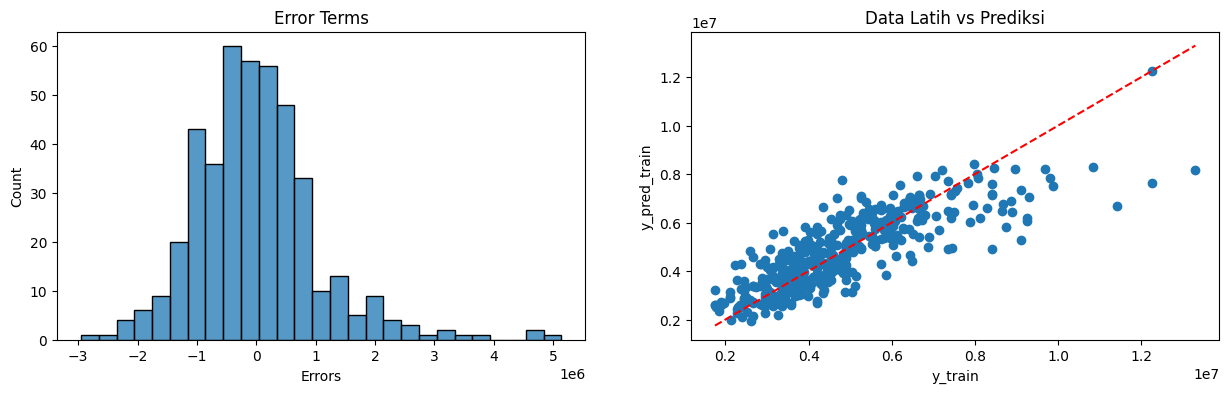

In [ ]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('Evaluasi Multiple Linear Regression Model')
print('Koefisien Model Regresi adalah ',MLR.coef_)
print('Intersep Model Regresi adalah ',MLR.intercept_)

evaluasi_model(0, pred1, pred2)

### 6.2 Lasso Linear Regression Model

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.000e+12, tolerance: 1.453e+11
  model = cd_fast.enet_coordinate_descent(
Evaluasi Lasso Regression Model
Koefisien Model Regresi adalah  [ 435611.14487023  178537.08295202  119686.19043233  171210.69906436
  200579.50566621  363541.20854777  271063.93568959   15089.68810468
 -168848.77251852  372226.61928913  188596.12151055  280135.39332289
  134056.09529587  228898.94191227  372492.08421671  166959.67892629
  278130.4967756   -57713.75636152  -34036.23385923  107449.71928897
  121382.08282259   39267.90167156   84597.20602996]
Intersep Model Regresi adalah  4716708.779342723


--------------------Metrik Data Train--------------------

R2-Score pada Data Train ---> 0.6789097088318172
Residual Sum of 

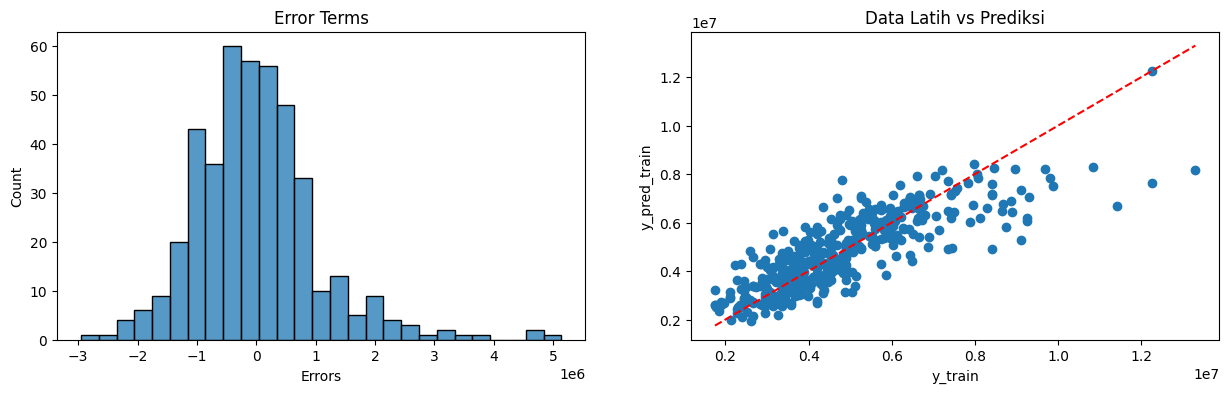

In [ ]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('Evaluasi Lasso Regression Model')
print('Koefisien Model Regresi adalah ',LLR.coef_)
print('Intersep Model Regresi adalah ',LLR.intercept_)

evaluasi_model(1, pred1, pred2)

### 6.3 Ridge Linear Regression Model

Evaluasi Lasso Regression Model
Koefisien Model Regresi adalah  [ 434849.91176123  178990.05639646  119825.2647667   170770.38332747
  200249.17623357  363249.0167767   270699.69394281   15052.8419874
 -168922.68102789  371839.95056242  188214.33365361  279471.70539682
  132951.62984324  227966.31622315  371469.35951183  166740.86406292
  277604.61004215  -57376.64786896  -59857.52583883   79155.30405199
  100178.60681446   31307.10402313   81636.0847929 ]
Intersep Model Regresi adalah  4716708.779342723


--------------------Metrik Data Train--------------------

R2-Score pada Data Train ---> 0.6789060979912986
Residual Sum of Squares (RSS) pada Data Train  ---> 466435055740620.56
Mean Squared Error (MSE) pada Data Train       ---> 1094917971222.1141
Root Mean Squared Error (RMSE) pada Data Train ---> 1046383.281222571

--------------------Metrik Data Test--------------------

R2-Score pada Data Uji ---> 0.6868090228048057
Residual Sum of Squares (RSS) pada Data Test  ---> 11599483657

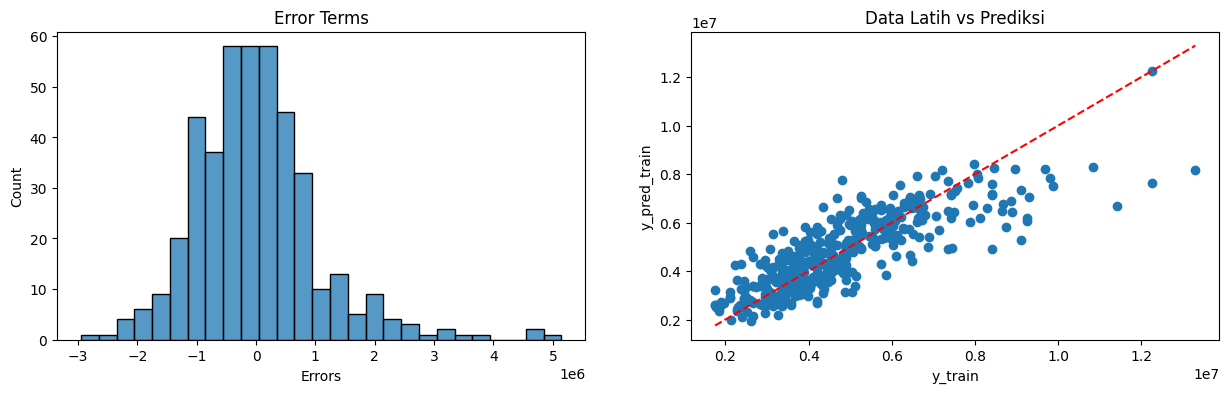

In [ ]:
R = Ridge().fit(Train_X_std,Train_Y)
pred1 = R.predict(Train_X_std)
pred2 = R.predict(Test_X_std)

print('Evaluasi Lasso Regression Model')
print('Koefisien Model Regresi adalah ',R.coef_)
print('Intersep Model Regresi adalah ',R.intercept_)

evaluasi_model(2, pred1, pred2)

In [ ]:
EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Lasso Linear Regression (LLR)','Ridge Linear Regression (RLR)']
EMC = EMC.reset_index().rename(columns={'index': 'Model'})
EMC

,Model,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
0,Multiple Linear Regression (MLR),0.678910,0.686679,4.664298e+14,1.160428e+14,1.094906e+12,1.084512e+12,1.046377e+06,1.041399e+06
1,Lasso Linear Regression (LLR),0.678910,0.686680,4.664298e+14,1.160425e+14,1.094906e+12,1.084509e+12,1.046377e+06,1.041398e+06
2,Ridge Linear Regression (RLR),0.678906,0.686809,4.664351e+14,1.159948e+14,1.094918e+12,1.084064e+12,1.046383e+06,1.041184e+06


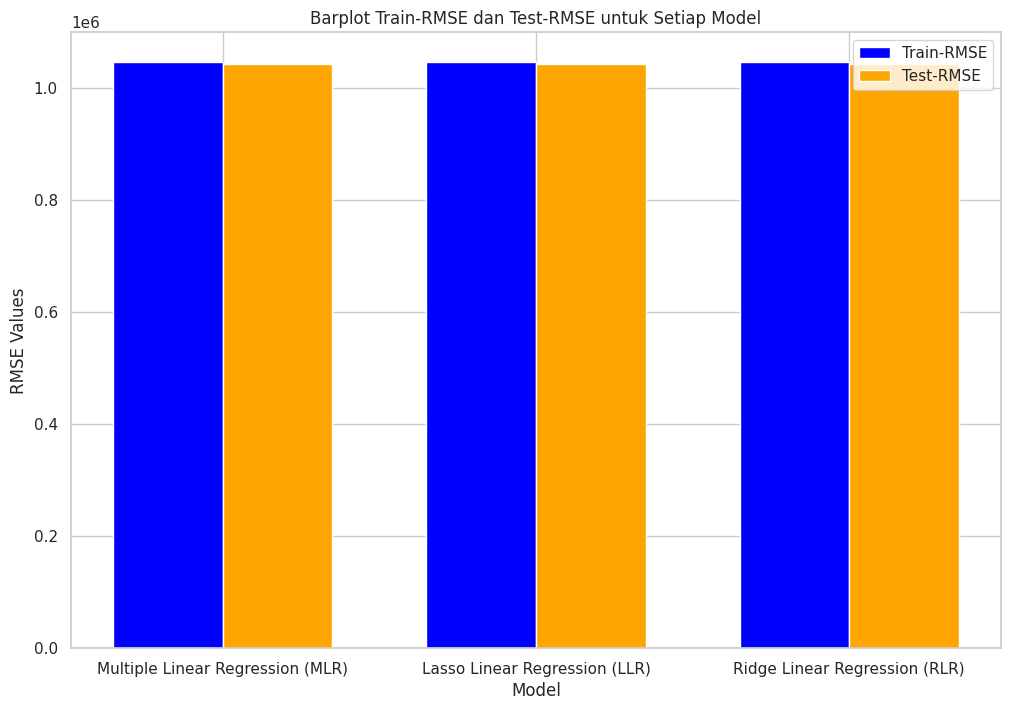

In [ ]:
# Membuat barplot menggunakan Seaborn untuk Train-RMSE dan Test-RMSE bersebelahan
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Menetapkan lebar bar untuk membuatnya bersebelahan
bar_width = 0.35

# Menghitung posisi x untuk Train-RMSE dan Test-RMSE
positions = np.arange(len(EMC['Model']))
train_rmse = positions - bar_width / 2
test_rmse = positions + bar_width / 2

# Membuat barplot untuk Train-RMSE dan Test-RMSE
plt.bar(train_rmse, EMC['Train-RMSE'], width=bar_width, label='Train-RMSE', color='blue')
plt.bar(test_rmse, EMC['Test-RMSE'], width=bar_width, label='Test-RMSE', color='orange')

# Menetapkan label dan judul plot
plt.xlabel('Model')
plt.ylabel('RMSE Values')
plt.title('Barplot Train-RMSE dan Test-RMSE untuk Setiap Model')
plt.xticks(positions, EMC['Model'])
plt.legend()

plt.show()

## Kesimpulan
Dari ketiga model diatas terlihat memiliki hasil yang hampir sama, namun jika dilihat pada perhitungan RMSE, Multiple Linear Regression memiliki nilai yang paling rendah yaitu berada pada 1046377.397 untuk Training dan 1041399.167 untuk Testing

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=12500a76-87fd-46d4-b1c6-f5fb745151c2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>